In [1]:
using Plots
pyplot()

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


Plots.PyPlotBackend()

In [29]:
using NumericalIntegration
using FFTW

In [2]:
push!(LOAD_PATH, "../src/VlasovSolver/")
push!(LOAD_PATH, "../src/MaxwellSolver/")

using PFCNonUniform
using StrangSplitting
using PoissonFourier1D

# Plasma oscillations on uniform grid

Here we perform a verification of long-lasting stability of the scheme for the case of longitudinal plasma oscillations.

Initial conditions for electrons are
$$
f(x, v) = \frac{1}{\sqrt{2\pi}}\exp\left\{-\frac{v^2}{2}\right\}\left(1 + \tilde n\cos kx\right)
$$
where velocities $v$ are normalised to a thermal velocity $v_{\rm th}$, concentration $n$ is normalized to equilibrium concentration $N_e$, spatial coordinate $x$ is normalized to $v_{\rm th} \over \omega_p$ where $\omega_p^2 = \frac{4\pi e^2 N_e}{m}$ is a plasma frequency ($e$ is the elemaentary charge and $m$ is the electron mass).

$k$ normalized to $\omega_p \over v_{\rm th}$ is a wave number. Here we verify the case $k \ll 1$ for which dispersion and Landau damping are negligible.

Ions are supposed to be uniformly distributed and immobile.

For simulations below we choose: $k = \frac{2\pi}{100}$, $\tilde n = 0.01$

Simulations are performed on a uniform grid $x \in (1,100)$, $\Delta x = 1$, $v \in (-4,4)$, $\Delta v = 0.1$, $t \in (0, 3000)$, $\Delta t = 0.1$

In [7]:
x = collect(1.0:1.0:100.0)
Δx = vcat([x[2]-x[1]], 0.5*(x[3:end] - x[1:end-2]), [x[end]-x[end-1]])
v = collect(-4:0.1:4)
Δv = vcat([v[2]-v[1]], 0.5*(v[3:end] - v[1:end-2]), [v[end]-v[end-1]])

advect_x! = make_advect_1D!(Δx)
advect_v! = make_advect_1D!(Δv)

fi = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. Δx/Δx)'
ni = integrate(v, fi)
Ni = integrate(x, ni)

f0 = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. (1.0 + 0.01*cos(2π*x/100)))'
n0 = integrate(v, f0)
N0 = integrate(x, n0)
f0 *= Ni/N0

f = copy(f0)

t = collect(0.0:0.1:3000.0)
n = t * n0'

ε = similar(t)
ε_e = similar(ε)

ω = 2π*collect(0.0:1.0/(x[end]-x[1]+x[2]-x[1]):0.5/(x[2]-x[1]))
ω[1] = ω[2]
    
e = similar(x)

g = f';

In [8]:
function run()
    global f, g, t, n, e, ε, ε_e, ω
    for k in 1:length(t)-1
        Δt = t[k+1] - t[k]
        
        function vΔt(f)
            return v*Δt
        end
        
        function eΔt(f)
            n[k,:] = sum(f'.*Δv, dims=1)'
            solve_poisson!(e, ω, n[k,:]-ni, Δx)
            return e*Δt
        end
        
        make_time_step_2d!((g, f), (vΔt, eΔt), (advect_x!, advect_v!))
        
        ε_e[k] = integrate(x, e.^2)
        ε[k] = integrate(x, integrate(v, @. f*v^2)) + ε_e[k]
    end
    n[end,:] = sum(f.*Δv, dims=1)'
    solve_poisson!(e, ω, n[end,:]-ni, Δx)
    ε_e[end] = integrate(x, e.^2)
    ε[end] = integrate(x, integrate(v, @. f*v^2)) + ε_e[end]
    return
end

run (generic function with 1 method)

In [9]:
@time run()

420.337261 seconds (8.11 G allocations: 270.372 GiB, 10.57% gc time)


Here we check conservation of energy calculating the total energy of the system as follows:

$$
\varepsilon = \iint f\frac{v^2}{2} dvdx + \int \frac{E^2}{2} dx
$$

where $E$ is an electric filed normalized to $\frac{m\omega_p v_{\rm th}}{e}$

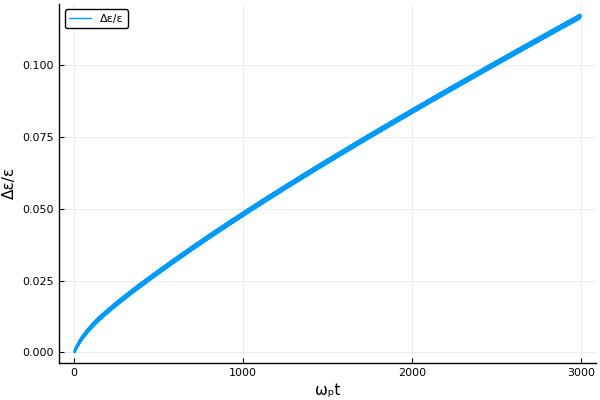

In [25]:
plot(t, (ε.-ε[1])./ε[1], label="Δε/ε")
xlabel!("ωₚt")
ylabel!("Δε/ε")

We see that despite slow growth a relative energy conservation violation is still below 0.5% at almost 500 wave periods.

Now we check the amplitude of plasma oscillations at central point where it reaches maximum.

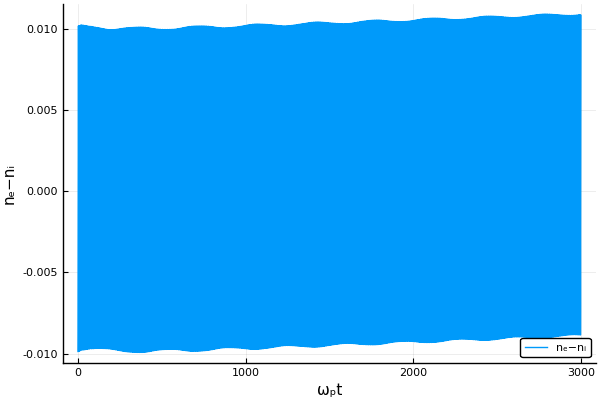

In [26]:
plot(t, n[:,end÷2].-ni[end÷2], label="nₑ−nᵢ")
xlabel!("ωₚt")
ylabel!("nₑ−nᵢ")

We see that the amplitude also stays stable close to initial 0.01 value.

Let us also check a frequency of the oscillations:

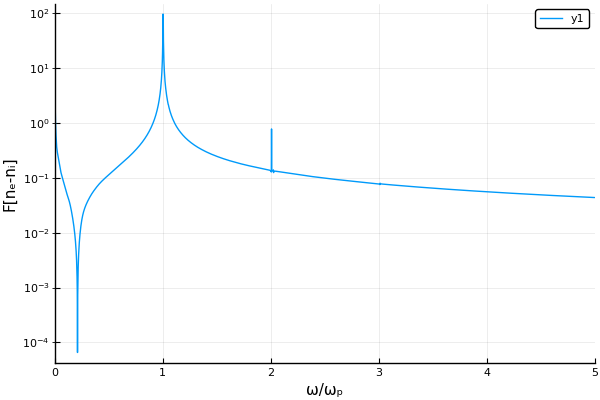

In [36]:
F = FFTW.rfft(n[:,end÷2].-ni[end÷2])
ω = 2π*collect(0.0:1.0/(t[end]-t[1]):0.5/(t[2]-t[1]))
plot(ω, abs.(F), yscale=:log10)
xlabel!("ω/ωₚ")
ylabel!("F[nₑ-nᵢ]")
xlims!(0,5)

We see a perfect coincidence.

# Plasma oscillations on non-uniform grid

Here we perform a verification of long-lasting stability of the scheme for the case of non-uniform grid.

Initial conditions and simulation parameters are the same except for grid along velocity axis. Now it isn't uniform:

$v \in (-4,4)$,

$\Delta v = 0.1 \iff |v| < 1$,

$\Delta v = 0.2 \iff |v| > 1$

In [20]:
x = collect(1.0:1.0:100.0)
Δx = vcat([x[2]-x[1]], 0.5*(x[3:end] - x[1:end-2]), [x[end]-x[end-1]])
v = vcat(collect(-4:0.2:-1.2), collect(-1:0.1:1), collect(1.2:0.2:4))
Δv = vcat([v[2]-v[1]], 0.5*(v[3:end] - v[1:end-2]), [v[end]-v[end-1]])

advect_x! = make_advect_1D!(Δx)
advect_v! = make_advect_1D!(Δv)

fi = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. Δx/Δx)'
ni = integrate(v, fi)
Ni = integrate(x, ni)

f0 = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. (1.0 + 0.01*cos(2π*x/100)))'
n0 = integrate(v, f0)
N0 = integrate(x, n0)
f0 *= Ni/N0

f = copy(f0)

t = collect(0.0:0.1:3000.0)
n = t * n0'

ε = similar(t)
ε_e = similar(ε)

ω = 2π*collect(0.0:1.0/(x[end]-x[1]+x[2]-x[1]):0.5/(x[2]-x[1]))
ω[1] = ω[2]
    
e = similar(x)

g = f';

In [21]:
function run()
    global f, g, t, n, e, ε, ε_e, ω
    for k in 1:length(t)-1
        Δt = t[k+1] - t[k]
        
        function vΔt(f)
            return v*Δt
        end
        
        function eΔt(f)
            n[k,:] = sum(f'.*Δv, dims=1)'
            solve_poisson!(e, ω, n[k,:]-ni, Δx)
            return e*Δt
        end
        
        make_time_step_2d!((g, f), (vΔt, eΔt), (advect_x!, advect_v!))
        
        ε_e[k] = integrate(x, e.^2)
        ε[k] = integrate(x, integrate(v, @. f*v^2)) + ε_e[k]
    end
    n[end,:] = sum(f.*Δv, dims=1)'
    solve_poisson!(e, ω, n[end,:]-ni, Δx)
    ε_e[end] = integrate(x, e.^2)
    ε[end] = integrate(x, integrate(v, @. f*v^2)) + ε_e[end]
    return
end

run (generic function with 1 method)

In [22]:
@time run()

276.306899 seconds (5.12 G allocations: 170.620 GiB, 12.90% gc time)


Again, let us check the energy conservation and the stability of the oscillations amplitude

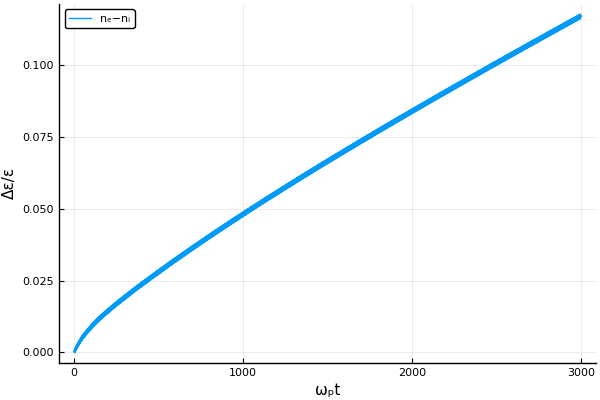

In [27]:
plot(t, (ε.-ε[1])./ε[1], label="nₑ−nᵢ")
xlabel!("ωₚt")
ylabel!("Δε/ε")

In this case, as clearly seen, the violation of energy conservation is more pronounced but still at reasonable level: even after almost 500 plasma oscillations it's only about 12%.

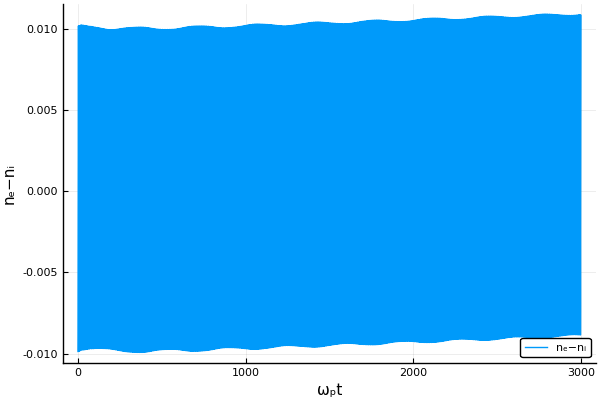

In [28]:
plot(t, n[:,end÷2].-ni[end÷2], label="nₑ−nᵢ")
xlabel!("ωₚt")
ylabel!("nₑ−nᵢ")

The stability of the oscillations amplitude is pretty the same as in the case of uniform grid. It points out that the energy growth is mainly due to heating of plasma and not due to a growth of some instability.